In [7]:
from tqdm import tqdm, trange
import numpy as np
import torch                                        # root package
from torch.utils.data import Dataset, DataLoader    # dataset representation and loading
from torch import Tensor                            # tensor node in the computation graph
import torch.nn as nn                               # neural networks
import torch.nn.functional as F                     # layers, activations and more
import torch.optim as optim                         # optimizers e.g. gradient descent, ADAM, etc.
from torchvision import datasets, models, transforms     # vision datasets, architectures & transforms
import torchvision.transforms as transforms              # composable transforms
from model import SimpleNet
from utils import *
import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


In [2]:
transform = transforms.Compose(
    [#transforms.AutoAugment(policy = transforms.AutoAugmentPolicy.CIFAR10),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
     ])

#scripted_transform =
batch_size = 64

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [5]:
model = SimpleNet().to(device)
print(model.modules)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [10,20], gamma=0.1)
n_epochs = 30
save_path = os.path.join('checkpoints',"bestmodel.pt")
print(save_path)

checkpoints\bestmodel.pt


In [4]:
best_accuracy = 0.0
for epoch in range(n_epochs):  # loop over the dataset multiple times
    model.train()
    
    loss_acc_train = 0
    correct_guesses_train = 0
    number_of_guesses_train = 0
    with tqdm(trainloader, desc=f"Train {epoch}", unit="batch", leave=True) as bt:
        for i, (images, labels) in enumerate(bt):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_acc_train += loss
            
            pred = outputs.max(1).indices
            correct_guesses_train += (labels == pred).sum().item()
            number_of_guesses_train += pred.size(0)
            
            bt.set_postfix(loss=loss_acc_train.item()/(i+1), accuracy=correct_guesses_train/number_of_guesses_train)
    
    model.eval()
    loss_acc_eval = 0
    correct_guesses_eval = 0
    number_of_guesses_eval = 0
    accuracy = 0
    with torch.no_grad():
        with tqdm(testloader, desc=f"Eval {epoch}", unit="batch", leave=True) as bt:
            for i, (images, labels) in enumerate(bt):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss_acc_eval += loss
                
                pred = outputs.max(1).indices
                correct_guesses_eval += (labels == pred).sum().item()
                number_of_guesses_eval += pred.size(0)
                accuracy = correct_guesses_eval/number_of_guesses_eval
                bt.set_postfix(loss=loss_acc_eval.item()/(i+1), accuracy=accuracy)
    
    if best_accuracy < accuracy:
        save_model(model, save_path)        
    
    scheduler.step()


print('Finished Training')

Eval 29: 100%|██████████| 157/157 [00:04<00:00, 33.99batch/s, accuracy=0.791, loss=0.645] 

Finished Training


# Attack

In [6]:
model = load_model(SimpleNet, dict(), save_path).to(device)
model.eval()

SimpleNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)

In [7]:
test_images = iter(testset)

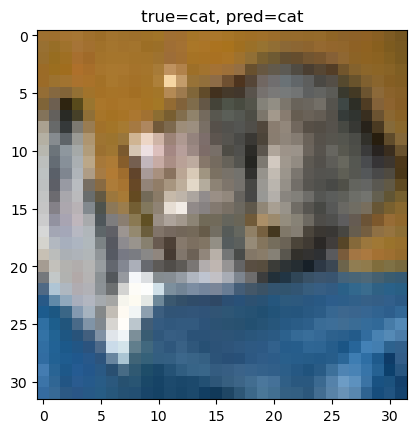

In [8]:
image, label = next(test_images)
#attack_label = 0
#print("attack_label", classes[attack_label])
#attack_label = torch.tensor([attack_label]).to(device)
show_image = transforms.ToPILImage()(image.to('cpu')/2 + 0.5)
image = image[None, ...]
pred = model(image.to(device))
plt.title('true='+ classes[label] + ", pred=" + classes[pred.max(1).indices])
plt.imshow(show_image)

## FGSM

In [8]:
def FGSM(model, image, attack_label, epsilon=5*1e-2):
    attacked_image = image.clone()
    attacked_image.requires_grad=True
    pred = model(attacked_image.to(device))
    criterion(pred, attack_label).backward()
    attacked_image.requires_grad=False
    attacked_image = attacked_image + epsilon*attacked_image.grad.sign()
    # attacked_image[attacked_image > 1.0] = 1.0
    # attacked_image[attacked_image < -1.0] = -1.0
    attacked_image.grad = None
    return attacked_image

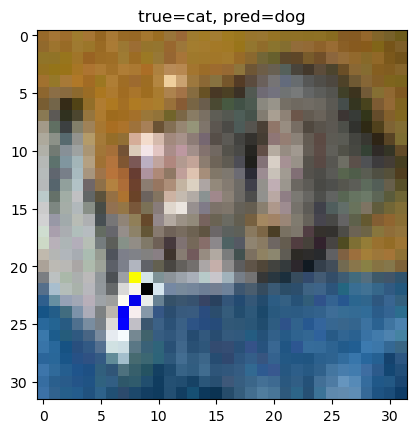

In [12]:
attacked_image = FGSM(model, image, torch.tensor([label]).to(device))
show_image = transforms.ToPILImage()(attacked_image[0].to('cpu')/2 + 0.5)
plt.title('true='+ classes[label] + ", pred=" + classes[model(attacked_image.to(device)).max(1).indices])
plt.imshow(show_image)

## PGM

In [517]:
def PGM(model, image, attack_label, epsilon=5*1e-2, delta=2*1e-2, t_max=10):
    attacked_image = image.clone()
    attacked_image = attacked_image.to(device)
    attack = torch.zeros_like(attacked_image).to(device)
    print(attack_label)
    pred = model(attacked_image)
    print(pred.max(1).indices)
    for _ in range(t_max):
        attacked_image.requires_grad = True
        pred = model(attacked_image)
        print(pred)
        #if pred.max(1).indices != attack_label:
        #    return attack
        criterion(pred, attack_label).backward()
        grad = attacked_image.grad
        attacked_image.grad = None
        attacked_image.requires_grad = False
        attack += delta * grad.sign()
        #if ((attack**2).sum()/(32*32*3)).sqrt() > epsilon:
        #    attack /= ((attack**2).sum()/(32*32*3)).sqrt()/epsilon
        if attack.max() > epsilon:
            attack = (attack/attack.max()) * epsilon
        if -attack.min() > epsilon:
            attack = (attack/-attack.min()) * epsilon
        
        attacked_image = image + attack
        
        attacked_image[attacked_image > 1.0] = 1.0
        attacked_image[attacked_image < -1.0] = -1.0
    
    pred = model(attacked_image)
    print(pred.max(1).indices)
    return attack

In [518]:
attack = PGM(model, image.to(device), torch.tensor([label]).to(device))

tensor([3], device='cuda:0')
tensor([3], device='cuda:0')
tensor([[-2.4975, -3.5724,  0.2193,  7.3883,  1.2094,  2.3996,  1.4863, -0.7910,
         -3.1892, -2.2534]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.7897, -2.7793,  0.7442,  3.9642,  2.0203,  2.2220,  0.1523,  0.7992,
         -2.9570, -2.0450]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.6977, -2.3786,  1.1161,  1.7811,  2.5348,  2.3782, -0.6595,  2.2379,
         -2.7409, -2.2268]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.7224, -2.5379,  0.9077,  1.1623,  3.0497,  2.7123, -1.2893,  3.5974,
         -2.9730, -2.5111]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.7643, -2.6937,  0.7435,  1.1606,  3.1198,  2.8027, -1.8253,  4.7439,
         -3.3000, -2.5359]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.7259, -2.7959,  0.6564,  1.1983,  2.9587,  2.8252, -2.4129,  5.8368,
         -3.6221, -2.4202]], device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.6370, -2.914

tensor([[-2.1485, -4.1714, -0.2782,  1.4332,  3.9646,  3.7881, -4.6414, 11.3863,
         -5.8687, -2.6630]], device='cuda:0', grad_fn=<AddmmBackward0>)


tensor([7], device='cuda:0')

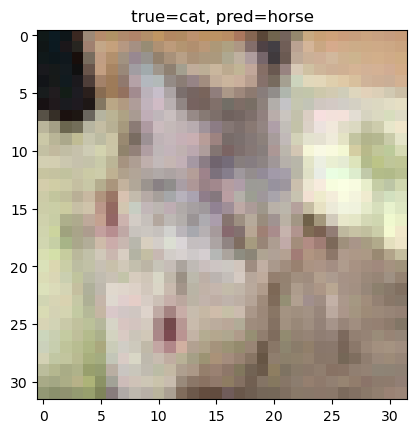

In [519]:
attacked_image = image.to(device) + attack 
attacked_image[attacked_image > 1.0] = 1.0
attacked_image[attacked_image < -1.0] = -1.0
pred = model(attacked_image.to(device))
show_image = transforms.ToPILImage()(attacked_image[0].to('cpu')/2 + 0.5)
plt.title('true='+ classes[label] + ", pred=" + classes[pred.max(1).indices])
plt.imshow(show_image)
print(pred)
pred.max(1).indices

## Defense

In [9]:
model = SimpleNet().to(device)
print(model.modules)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-3)
#optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=1e-5)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [10,20], gamma=0.1)
n_epochs = 30
save_path_defense = os.path.join('checkpoints',"bestmodel_defense.pt")
print(save_path_defense)


<bound method Module.modules of SimpleNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=21632, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout1): Dropout2d(p=0.3, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
)>
checkpoints\bestmodel_defense.pt


In [10]:
best_accuracy = 0.0
for epoch in range(n_epochs):  # loop over the dataset multiple times
    model.train()
    
    m_loss_acc_train = 0.0
    a_loss_acc_train = 0.0
    correct_guesses_train = 0
    number_of_guesses_train = 0
    with tqdm(trainloader, desc=f"Train {epoch}", unit="batch", leave=True) as bt:
        for i, (images, labels) in enumerate(bt):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(images)
            attacked_images = FGSM(model, images, labels, epsilon=1e-1)
            attacked_images.grad = None
            attacked_outputs = model(attacked_images)
            optimizer.zero_grad()
            
            misclassification_loss = criterion(outputs, labels)
            adversarial_loss = criterion(attacked_outputs, labels)
            
            loss = misclassification_loss + adversarial_loss
            loss.backward()
            optimizer.step()
            
            m_loss_acc_train += misclassification_loss
            a_loss_acc_train += adversarial_loss
            pred = outputs.max(1).indices
            correct_guesses_train += (labels == pred).sum().item()
            number_of_guesses_train += pred.size(0)
            
            bt.set_postfix(m_loss_acc_train=m_loss_acc_train.item()/(i+1), a_loss_acc_train=a_loss_acc_train.item()/(i+1), accuracy=correct_guesses_train/number_of_guesses_train)
    
    model.eval()
    m_loss_acc_eval = 0
    a_loss_acc_eval = 0
    correct_guesses_eval = 0
    number_of_guesses_eval = 0
    accuracy = 0
    #with torch.no_grad():
    with tqdm(testloader, desc=f"Eval {epoch}", unit="batch", leave=True) as bt:
        for i, (images, labels) in enumerate(bt):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            attacked_images = FGSM(model, images, labels, epsilon=1e-1)
            attacked_images.grad = None
            attacked_outputs = model(attacked_images)
            misclassification_loss = criterion(outputs, labels)
            adversarial_loss = criterion(attacked_outputs, labels)
            
            m_loss_acc_eval += misclassification_loss
            a_loss_acc_eval += adversarial_loss
            
            pred = outputs.max(1).indices
            correct_guesses_eval += (labels == pred).sum().item()
            number_of_guesses_eval += pred.size(0)
            accuracy = correct_guesses_eval/number_of_guesses_eval
            bt.set_postfix(m_loss=m_loss_acc_eval.item()/(i+1), a_loss=a_loss_acc_eval.item()/(i+1), accuracy=accuracy)
    
    if best_accuracy < accuracy:
        save_model(model, save_path_defense)        
    
    scheduler.step()


print('Finished Training')

Eval 0:  70%|███████   | 110/157 [00:06<00:02, 17.84batch/s, a_loss=2.18, accuracy=0.467, m_loss=1.53]


OutOfMemoryError: CUDA out of memory. Tried to allocate 44.00 MiB (GPU 0; 8.00 GiB total capacity; 6.88 GiB already allocated; 0 bytes free; 7.29 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF